In [1]:
!pip install transformers -q
!pip install sentencepiece -q

     |████████████████████████████████| 3.1 MB 4.3 MB/s 
     |████████████████████████████████| 596 kB 61.0 MB/s 
     |████████████████████████████████| 3.3 MB 58.1 MB/s 
     |████████████████████████████████| 61 kB 422 kB/s 
     |████████████████████████████████| 895 kB 64.9 MB/s 
     |████████████████████████████████| 1.2 MB 4.1 MB/s 


In [2]:
import datetime
import os
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau, ExponentialLR
from torch.utils.data import Dataset, DataLoader, IterableDataset

from transformers import AutoModel, AutoTokenizer, AutoConfig

from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import compute_class_weight

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from IPython.display import display, HTML

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
def get_data_loader(dataset, batch_size=16, random_seed=42):
    g = torch.Generator()
    g.manual_seed(random_seed)
    return DataLoader(dataset, batch_size=batch_size, generator=g)

In [5]:
def get_seq_masks(chkpoint, txt):
  tokenizer = AutoTokenizer.from_pretrained(chkpoint)
  all_tokens = tokenizer.batch_encode_plus(txt, max_length=96,
                                             padding='longest',
                                             truncation=True,
                                             return_token_type_ids=False)
  sequences = torch.tensor(all_tokens['input_ids'])
  attention_masks = torch.tensor(all_tokens['attention_mask'])
  return sequences, attention_masks

In [28]:
class FusionDataset(IterableDataset):
    def __init__(self, chkpoint, lyrics, features, labels, fsize=(12,1876)):
        self.sequences, self.masks = get_seq_masks(chkpoint, lyrics)
        self.labels = labels
        self.features = features
        self.fsize = fsize
    
    def __get__(self,index):
      if self.features[index].shape[1] < self.fsize[1]:
        self.features[index] = torch.hstack((self.features[index],
                                             torch.zeros(self.fsize[0],self.fsize[1]-self.features[index].shape[1])))
      return self.features[index].reshape((1,)+self.features[index].shape)

    def __len__(self):
        return len(self.labels)

    def __iter__(self):
        for index, _ in enumerate(self.labels):
            yield self.sequences[index], self.masks[index], self.__get__(index), self.labels[index]

    def __getitem__(self, index):
        return self.sequences[index], self.masks[index], self.__get__(index), self.labels[index]

    def get_data_loader(self, batch_size=16, random_seed=42):
        return get_data_loader(self, batch_size, random_seed)
    
    @staticmethod
    def _prepare_data_(data, chkpoint, ids, target='RagamCode', audfeature='mel_spec', fsize=(12,1876)):
      lbls = torch.tensor([data[target].iloc[x] for x in ids])
      lyrics = [data['Lyric'].iloc[x] for x in ids]
      features = [data[audfeature].iloc[x] for x in ids] # aud feature is already tensor
      return FusionDataset(chkpoint, lyrics, features, lbls, fsize)

    @staticmethod
    def prepare_data(data, chkpoint, train_ids, test_ids, target='RagamCode', audfeature='mel_spec', fsize=(12,1876)): 
      return FusionDataset._prepare_data_(data, chkpoint, train_ids, target, audfeature, fsize), FusionDataset._prepare_data_(data, chkpoint, train_ids, target, audfeature, fsize)

In [7]:
class FusionModel(nn.Module):
  def __init__(self, transformer, n_labels=2, dropout=0.1):
    super().__init__()
    self.VEC_SIZE = 768
    self.transformer = transformer
    self.aud_layer = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(1,1), padding='same'),            
            nn.ReLU(),
            nn.Conv2d(in_channels=1, out_channels=2, kernel_size=(2,2), padding='same'),            
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.AvgPool2d(kernel_size=4),
            nn.Flatten()
        )
    self.fusion = nn.Sequential(nn.Linear(2814+self.VEC_SIZE, 1000),
                                nn.ReLU(),
                                nn.Dropout(dropout),
                                nn.Linear(1000, n_labels))
  def forward(self, sequence, mask, aud):
    _, cls = self.transformer(sequence, attention_mask=mask, return_dict=False)
    aud = self.aud_layer(aud)
    x = torch.cat((aud, cls),1)
    return self.fusion(x)

In [8]:
def get_devices():
    if torch.cuda.is_available():
        gpu = torch.device("cuda")
    else:
        gpu = torch.device("cpu")
    cpu = torch.device("cpu")
    return gpu, cpu
gpu, cpu = get_devices()

In [9]:
def get_loss_function(balance_classes, labels, run_on, loss_fcn=nn.CrossEntropyLoss):
    if balance_classes:
        class_wts = compute_class_weight(class_weight='balanced',
                                         classes=np.unique(labels),
                                         y=labels
                                         )
        print(f'Class Weights : {class_wts}')
        # convert class weights to tensor
        weights = torch.tensor(class_wts, dtype=torch.float)
        weights = weights.to(run_on)
        # loss function
        loss_fcn = loss_fcn(weight=weights)
    else:
        loss_fcn = loss_fcn()
    return loss_fcn

In [10]:
def get_metrics(actual, predicted, average='weighted'):
  return f1_score(actual, predicted, average=average), precision_score(actual, predicted, average=average), recall_score(actual, predicted, average=average)

In [11]:
def update_best_result(best_scores, valid_loss, train_labels, train_predictions, validation_labels,
                       validation_predictions, test_labels, test_predictions,
                       model=None, model_file_name=f'saved_weights_Fold_0.pt'):
    if valid_loss < best_scores['valid_loss']:
        best_scores['valid_loss'] = valid_loss
        best_scores['train_predictions'] = train_predictions
        best_scores['validation_predictions'] = validation_predictions
        best_scores['test_predictions'] = test_predictions
        best_scores['train_labels'] = train_labels
        best_scores['validation_labels'] = validation_labels
        best_scores['test_labels'] = test_labels
        if model:
            torch.save(model.state_dict(), model_file_name)
    return best_scores


def update_results_dict(results, train_labels, train_predictions, validation_labels, validation_predictions,
                        test_lbls, test_preds,
                        average='micro', pos_label=1):
    results['train_precision'].append(precision_score(train_labels, train_predictions, average=average))
    results['train_recall'].append(recall_score(train_labels, train_predictions, average=average))
    results['train_f1'].append(f1_score(train_labels, train_predictions, average=average))
    results['validation_precision'].append(precision_score(validation_labels, validation_predictions, average=average))
    results['validation_recall'].append(recall_score(validation_labels, validation_predictions, average=average))
    results['validation_f1'].append(
        f1_score(validation_labels, validation_predictions, average=average))
    results['test_precision'].append(precision_score(test_lbls, test_preds, average=average))
    results['test_recall'].append(recall_score(test_lbls, test_preds, average=average))
    results['test_f1'].append(
        f1_score(test_lbls, test_preds, average=average))
    results['train_labels'].append([train_labels])
    results['validation_labels'].append([validation_labels])
    results['test_labels'].append([test_lbls])
    results['train_predictions'].append([train_predictions])
    results['validation_predictions'].append([validation_predictions])
    results['test_predictions'].append([test_preds])
    return results

In [12]:
def run_model(model, dataset, loss_fcn, optimizer, is_training, run_on, clip_at=None, lstm_model=False, report_at=20):
    if is_training:
        model.train()
    else:
        model.eval()
    total_loss, total_accuracy, model_predictions, model_labels, aud_data = 0, 0, [], [], None
    for step, batch in enumerate(dataset):
        # push the batch to gpu
        batch = [r.to(run_on) for r in batch]
        sequences, masks, features, labels = batch
        if is_training:
            for o in optimizer:
                o.zero_grad()
            model.zero_grad()
            predictions = model(sequences, masks, features)
        else:
            with torch.no_grad(): 
              predictions = model(sequences, masks, features)
        # compute the loss between actual and predicted values
        loss = loss_fcn(predictions, labels)
        predictions = predictions.detach().cpu().numpy()
        total_loss = total_loss + loss.item()
        if is_training:
            loss.backward()  # backward pass to calculate the gradients
            if clip_at:
                torch.nn.utils.clip_grad_norm_(model.parameters(), clip_at)
            # update parameters
            for o in optimizer:
                o.step()
        # append the model predictions
        model_predictions.append(predictions)
        model_labels.append(labels.detach().cpu().numpy())
        del batch
    # compute the training loss of the epoch
    avg_loss = total_loss / len(dataset)
    # predictions are in the form of (no. of batches, size of batch, no. of classes).
    # reshape the predictions in form of (number of samples, no. of classes)
    model_predictions = np.concatenate(model_predictions, axis=0)
    model_labels = np.concatenate(model_labels, axis=0)
    # returns the loss and predictions
    model_predictions = np.argmax(model_predictions, axis=1)
    return avg_loss, model_predictions, model_labels

In [13]:
def plot_results(results, model_name):
    fig = plt.figure(figsize=[20, 10])
    epochs = len(results[0]['train_precision'])
    x_label = f'{len(results)} Fold and {epochs} Epochs'

    def subplot_routine(key1, key2, title, loss=False, key3=None):
        plt.plot([x for k in results for x in results[k][key1]])
        plt.plot([x for k in results for x in results[k][key2]])
        if key3:
          plt.plot([x for k in results for x in results[k][key3]])
        plt.grid()
        plt.xlabel(x_label)
        if key3:
          plt.legend([f'{x} {title}' for x in ['Train', 'Val','Test']])
        else:
          plt.legend([f'{x} {title}' for x in ['Train', 'Val']])
        if not loss:
            plt.ylim([0, 1.1])
        else:
            b, t = plt.ylim()
            plt.ylim(np.floor(b), np.ceil(t))

    plt.subplot(2,1,1)
    subplot_routine('train_losses', 'validation_losses', 'Losses', True)
    plt.subplot(2,1,2)
    subplot_routine('train_f1', 'validation_f1', 'F1', key3='test_f1')
    plt.suptitle(f'Metrics for {model_name}')
    plt.tight_layout()
    plt.show()

In [14]:
def results_to_df(results):
    p = pd.DataFrame(results[0])
    for i in range(1, len(results)):
        p = pd.concat([p, pd.DataFrame(results[i])], axis=0)
    p.sort_values(by=['validation_f1', 'train_f1'], ascending=False, inplace=True)
    return p

In [15]:
def load_tx_model(rootpath):
  return AutoModel.from_pretrained(os.path.join(rootpath,'pytorch_model.bin'), local_files_only=True,
                                  config=AutoConfig.from_pretrained(os.path.join(rootpath,'config.json')))

In [25]:
def predict_test_data(model, chkpoint, test_data, gpu, feature='mel_spec', target='RagamCode'):
  txt = list(test_data.apply(lambda x: x.Lyric, axis=1))
  sequences, masks = get_seq_masks(chkpoint, txt)
  model = model.to(gpu)
  ds = FusionDataset(chkpoint, txt, test_data[feature].tolist(), test_data[target].tolist())
  model.eval()
  preds, truth = [], []
  for step, batch in enumerate(ds.get_data_loader(16)):
    batch = [r.to(gpu) for r in batch]
    sequences, masks, features, labels = batch
    with torch.no_grad():
      preds_batch = model(sequences, masks, features)
    preds_batch = preds_batch.detach().cpu().numpy()
    preds.append(preds_batch)
    truth.append(labels.detach().cpu().numpy())
    del batch
  preds = np.concatenate(preds, axis=0)
  truth = np.concatenate(truth, axis=0)
  preds = np.argmax(preds, axis=1)
  return preds, truth

In [29]:
def train_model(data, test_data, rootpath, gpu, chkpoint, **kwargs):
    start_time = datetime.datetime.now()

    n_labels = kwargs['n_labels']
    title = kwargs['title']
    random_seed = kwargs['random_seed'] if 'random_seed' in kwargs else 42
    report = kwargs['report'] if 'report' in kwargs else 20
    lstm = kwargs['lstm'] if 'lstm' in kwargs else False
    lr = kwargs['lr'] if 'lr' in kwargs else 1e-4
    clip_at = kwargs['clip_at'] if 'clip_at' in kwargs else None
    k_folds = kwargs['k_folds'] if 'k_folds' in kwargs else 5
    balance_classes = kwargs['balance_classes'] if 'balance_classes' in kwargs else True
    dropout = kwargs['dropout'] if 'dropout' in kwargs else 0.1
    plot = kwargs['plot'] if 'plot' in kwargs else True
    epochs = kwargs['epochs'] if 'epochs' in kwargs else 5
    mdlargs = kwargs['mdlargs'] if 'mdlargs' in kwargs else {}
    feature = kwargs['feature'] if 'feature' in kwargs else ['mfcc_mean']
    target = kwargs['target'] if 'target' in kwargs else 'RagamCode'
    fsize = kwargs['fsize'] if 'fsize' in kwargs else (12,1876)
    loss_fcn = kwargs['loss_fcn'] if 'loss_fcn' in kwargs else None
    model_name = kwargs['model_name'] if 'model_name' in kwargs else 'model_state.pt'
    batch_size = kwargs['batch_size'] if 'batch_size' in kwargs else 32

    torch.manual_seed(random_seed)
    k_fold = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=random_seed)
    results = {x: {} for x in range(k_folds)}
    ovl_best_scores = {'valid_loss': float('inf'),
                       'train_predictions': [],
                       'validation_predictions': [],
                       'train_labels': [],
                       'validation_labels': []
                       }
    cv_score = {'train_predictions': [],
                'validation_predictions': [],
                'train_labels': [],
                'validation_labels': [],
                'test_predictions' : [],
                'test_labels' : []
                }
    for fold, (train_ids, validation_ids) in enumerate(k_fold.split(data[feature], data[target])):
        print(f'FOLD {fold + 1} \n Data Sizes (Train/Validation) : {len(train_ids)}/{len(validation_ids)}')
        fold_start = datetime.datetime.now()
        # empty lists to store training and validation loss of each epoch
        train_losses, valid_losses = [], []
        best_scores = {'valid_loss': float('inf'),
                       'train_predictions': [],
                       'validation_predictions': [],
                       'test_predictions' :[],
                       'train_labels': [],
                       'validation_labels': [],
                       'test_labels' : []
                       }
        # for each epoch
        results[fold] = {
            'train_f1': [],
            'validation_f1': [],
            'test_f1' : [],
            'train_precision': [],
            'validation_precision': [],
            'test_precision' :[],
            'train_recall': [],
            'validation_recall': [],
            'test_recall' :[],
            'train_labels': [],
            'validation_labels': [],
            'test_labels' : [],
            'train_predictions': [],
            'validation_predictions': [],
            'test_predictions':[]
        }
        train_data, validation_data = FusionDataset.prepare_data(data, chkpoint, train_ids, validation_ids, target, feature, fsize)
        transformer = load_tx_model(rootpath)
        model = kwargs['model'](transformer, dropout=dropout, **mdlargs)
        model.to(gpu)
        if not loss_fcn:
            loss_fcn = get_loss_function(balance_classes, data[target].tolist(), gpu, nn.CrossEntropyLoss)
        # define the optimizer
        optimizer = [torch.optim.Adam(model.parameters(), lr=lr),
                     torch.optim.SGD(model.parameters(), lr=lr, weight_decay=0.8)]
        lr_schedulers = [ReduceLROnPlateau(optimizer[0], patience=3, factor=0.1, threshold=1e-9, mode='min'),
                         ExponentialLR(optimizer[0], gamma=0.9)]
        for epoch in range(epochs):
            e_start = datetime.datetime.now()
            # train model
            train_loss, train_predictions, train_labels = run_model(model,
                                                                    train_data.get_data_loader(batch_size=batch_size),
                                                                    loss_fcn, optimizer, run_on=gpu,
                                                                    is_training=True, clip_at=clip_at,
                                                                    lstm_model=lstm, report_at=report)
            # evaluate model
            valid_loss, validation_predictions, validation_labels = run_model(model,
                                                                              validation_data.get_data_loader(
                                                                              batch_size=batch_size),
                                                                              loss_fcn, optimizer, run_on=gpu,
                                                                              is_training=False, clip_at=clip_at,
                                                                              lstm_model=lstm, report_at=report)
            for lr_scheduler in lr_schedulers:
                lr_scheduler.step(valid_loss)
            torch.cuda.empty_cache()
            # save the best model
            test_preds, test_lbls = predict_test_data(model, chkpoint, test_data, gpu, feature=feature, target=target)
            best_scores = update_best_result(best_scores,
                                             valid_loss,
                                             train_labels, train_predictions,
                                             validation_labels, validation_predictions,
                                             test_lbls, test_preds)
            ovl_best_scores = update_best_result(ovl_best_scores,
                                                 valid_loss,
                                                 train_labels, train_predictions,
                                                 validation_labels, validation_predictions,
                                                 test_lbls, test_preds,
                                                 model=model,
                                                 model_file_name=f'{model_name}')
            # append training and validation loss
            train_losses.append(train_loss)
            valid_losses.append(valid_loss)
            results[fold] = update_results_dict(results[fold],
                                                train_labels, train_predictions,
                                                validation_labels, validation_predictions,
                                                test_lbls, test_preds)
            e_end = datetime.datetime.now()
            print(
                f'Epoch {epoch + 1}/{epochs} : Training Loss: {train_loss:.3f} / Validation Loss : {valid_loss:.3f} [Time : {(e_end - e_start).total_seconds()} seconds]')
        print('*** Confusion Matrix - Training ***')
        print(confusion_matrix(best_scores['train_labels'], best_scores['train_predictions']))
        print('*** Confusion Matrix - Validation ***')
        print(confusion_matrix(best_scores['validation_labels'], best_scores['validation_predictions']))
        results[fold]['train_losses'] = train_losses
        results[fold]['validation_losses'] = valid_losses
        print(f'Fold {fold + 1} : {(datetime.datetime.now() - fold_start).total_seconds()} seconds')
        # To ensure CUDA is not overloaded
        del model
        cv_score['train_labels'] = cv_score['train_labels'] + best_scores['train_labels'].tolist()
        cv_score['train_predictions'] = cv_score['train_predictions'] + best_scores['train_predictions'].tolist()
        cv_score['validation_labels'] = cv_score['validation_labels'] + best_scores['validation_labels'].tolist()
        cv_score['validation_predictions'] = cv_score['validation_predictions'] + best_scores['validation_predictions'].tolist()
        cv_score['test_labels'] = cv_score['test_labels'] + best_scores['test_labels'].tolist()
        cv_score['test_predictions'] = cv_score['test_predictions'] + best_scores['test_predictions'].tolist()
        print('*** Confusion Matrix - Testing ***')
        print(get_metrics(cv_score['test_labels'],cv_score['test_predictions']))
    end_time = datetime.datetime.now()
    print(f'Overall Time : {(end_time - start_time).total_seconds()} seconds')
    print('*** Confusion Matrix - Training ***')
    print(confusion_matrix(ovl_best_scores['train_labels'], ovl_best_scores['train_predictions']))
    print('*** Confusion Matrix - Validation ***')
    print(confusion_matrix(ovl_best_scores['validation_labels'], ovl_best_scores['validation_predictions']))
    if plot:
        plot_results(results, title)
    cv_result = {}
    cv_result['validation_f1'], cv_result['validation_precision'], cv_result['validation_recall'] = get_metrics(cv_score['validation_labels'],cv_score['validation_predictions'])
    cv_result['test_f1'], cv_result['test_precision'], cv_result['test_recall'] = get_metrics(cv_score['test_labels'],cv_score['test_predictions'])
    cv_result['train_f1'], cv_result['train_precision'], cv_result['train_recall'] = get_metrics(cv_score['train_labels'],cv_score['train_predictions'])
    print('*** Cross Validation Score ***')
    cv_result = pd.DataFrame(cv_result, index=[0]) # Scalar values
    display(HTML(cv_result.to_html().replace("\\n", "<br>")))
    return results

In [18]:
data = pd.read_pickle('/content/drive/MyDrive/mp3_chroma.pkl')
labels = torch.tensor(data['RagamCode'].tolist())
n_labels = len(data['RagamCode'].unique())
res_tbl_keys = ['train_f1','validation_f1','test_f1','train_precision','validation_precision','test_precision','train_recall','validation_recall','test_recall']

In [19]:
# Held out 10% Data
from sklearn.model_selection import train_test_split
Y1, Y2 = train_test_split(data['RagamCode'], test_size=0.1, random_state=42)

test_data = data.loc[Y2.index]
data = data.loc[Y1.index]

In [20]:
N_EPOCHS = 30

# Fusion with IndicBERT and MEL Spectrogram

FOLD 1 
 Data Sizes (Train/Validation) : 820/205


Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Class Weights : [0.83333333 2.27777778 2.00980392 1.36666667 2.62820513 3.10606061
 1.13888889 1.36666667 0.94907407 1.79824561 1.42361111 3.41666667
 0.75925926 0.52564103 2.84722222 1.13888889 1.31410256 2.00980392
 2.44047619 2.44047619 0.66993464 0.63271605 0.38825758 1.70833333
 0.56010929 1.2202381  0.56010929 0.4495614  3.41666667 0.39272031]
Epoch 1/30 : Training Loss: 3.402 / Validation Loss : 3.391 [Time : 28.957348 seconds]
Epoch 2/30 : Training Loss: 3.390 / Validation Loss : 3.386 [Time : 28.921109 seconds]
Epoch 3/30 : Training Loss: 3.385 / Validation Loss : 3.378 [Time : 28.776422 seconds]
Epoch 4/30 : Training Loss: 3.377 / Validation Loss : 3.371 [Time : 29.006689 seconds]
Epoch 5/30 : Training Loss: 3.370 / Validation Loss : 3.363 [Time : 28.794817 seconds]
Epoch 6/30 : Training Loss: 3.362 / Validation Loss : 3.355 [Time : 28.783711 seconds]
Epoch 7/30 : Training Loss: 3.354 / Validation Loss : 3.348 [Time : 28.789049 seconds]
Epoch 8/30 : Training Loss: 3.345 / Val

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/30 : Training Loss: 3.401 / Validation Loss : 3.396 [Time : 28.60695 seconds]
Epoch 2/30 : Training Loss: 3.394 / Validation Loss : 3.389 [Time : 28.550295 seconds]
Epoch 3/30 : Training Loss: 3.388 / Validation Loss : 3.384 [Time : 28.487366 seconds]
Epoch 4/30 : Training Loss: 3.381 / Validation Loss : 3.377 [Time : 28.491079 seconds]
Epoch 5/30 : Training Loss: 3.374 / Validation Loss : 3.368 [Time : 28.506558 seconds]
Epoch 6/30 : Training Loss: 3.366 / Validation Loss : 3.360 [Time : 28.535768 seconds]
Epoch 7/30 : Training Loss: 3.358 / Validation Loss : 3.354 [Time : 28.527914 seconds]
Epoch 8/30 : Training Loss: 3.350 / Validation Loss : 3.349 [Time : 28.498095 seconds]
Epoch 9/30 : Training Loss: 3.344 / Validation Loss : 3.335 [Time : 28.532213 seconds]
Epoch 10/30 : Training Loss: 3.336 / Validation Loss : 3.325 [Time : 28.611217 seconds]
Epoch 11/30 : Training Loss: 3.321 / Validation Loss : 3.315 [Time : 28.560554 seconds]
Epoch 12/30 : Training Loss: 3.312 / Valid

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/30 : Training Loss: 3.412 / Validation Loss : 3.396 [Time : 28.447839 seconds]
Epoch 2/30 : Training Loss: 3.395 / Validation Loss : 3.387 [Time : 28.472332 seconds]
Epoch 3/30 : Training Loss: 3.388 / Validation Loss : 3.380 [Time : 28.477539 seconds]
Epoch 4/30 : Training Loss: 3.384 / Validation Loss : 3.372 [Time : 28.487548 seconds]
Epoch 5/30 : Training Loss: 3.372 / Validation Loss : 3.364 [Time : 28.48482 seconds]
Epoch 6/30 : Training Loss: 3.365 / Validation Loss : 3.355 [Time : 28.460631 seconds]
Epoch 7/30 : Training Loss: 3.354 / Validation Loss : 3.347 [Time : 28.444818 seconds]
Epoch 8/30 : Training Loss: 3.349 / Validation Loss : 3.336 [Time : 28.545387 seconds]
Epoch 9/30 : Training Loss: 3.338 / Validation Loss : 3.328 [Time : 28.605736 seconds]
Epoch 10/30 : Training Loss: 3.329 / Validation Loss : 3.320 [Time : 28.442573 seconds]
Epoch 11/30 : Training Loss: 3.321 / Validation Loss : 3.307 [Time : 28.433136 seconds]
Epoch 12/30 : Training Loss: 3.312 / Valid

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/30 : Training Loss: 3.405 / Validation Loss : 3.397 [Time : 28.511848 seconds]
Epoch 2/30 : Training Loss: 3.396 / Validation Loss : 3.392 [Time : 28.389596 seconds]
Epoch 3/30 : Training Loss: 3.391 / Validation Loss : 3.387 [Time : 28.420258 seconds]
Epoch 4/30 : Training Loss: 3.387 / Validation Loss : 3.384 [Time : 28.485255 seconds]
Epoch 5/30 : Training Loss: 3.382 / Validation Loss : 3.375 [Time : 28.411782 seconds]
Epoch 6/30 : Training Loss: 3.374 / Validation Loss : 3.368 [Time : 28.577849 seconds]
Epoch 7/30 : Training Loss: 3.369 / Validation Loss : 3.364 [Time : 28.553446 seconds]
Epoch 8/30 : Training Loss: 3.357 / Validation Loss : 3.359 [Time : 28.540641 seconds]
Epoch 9/30 : Training Loss: 3.350 / Validation Loss : 3.344 [Time : 28.468854 seconds]
Epoch 10/30 : Training Loss: 3.341 / Validation Loss : 3.343 [Time : 28.44655 seconds]
Epoch 11/30 : Training Loss: 3.331 / Validation Loss : 3.334 [Time : 28.453486 seconds]
Epoch 12/30 : Training Loss: 3.321 / Valid

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/30 : Training Loss: 3.404 / Validation Loss : 3.397 [Time : 28.477821 seconds]
Epoch 2/30 : Training Loss: 3.396 / Validation Loss : 3.392 [Time : 28.48055 seconds]
Epoch 3/30 : Training Loss: 3.392 / Validation Loss : 3.388 [Time : 28.49979 seconds]
Epoch 4/30 : Training Loss: 3.386 / Validation Loss : 3.383 [Time : 28.482268 seconds]
Epoch 5/30 : Training Loss: 3.382 / Validation Loss : 3.378 [Time : 28.65772 seconds]
Epoch 6/30 : Training Loss: 3.377 / Validation Loss : 3.374 [Time : 28.491939 seconds]
Epoch 7/30 : Training Loss: 3.372 / Validation Loss : 3.367 [Time : 28.433759 seconds]
Epoch 8/30 : Training Loss: 3.366 / Validation Loss : 3.362 [Time : 28.52125 seconds]
Epoch 9/30 : Training Loss: 3.363 / Validation Loss : 3.365 [Time : 28.498941 seconds]
Epoch 10/30 : Training Loss: 3.359 / Validation Loss : 3.369 [Time : 28.481815 seconds]
Epoch 11/30 : Training Loss: 3.359 / Validation Loss : 3.372 [Time : 28.44944 seconds]
Epoch 12/30 : Training Loss: 3.368 / Validatio

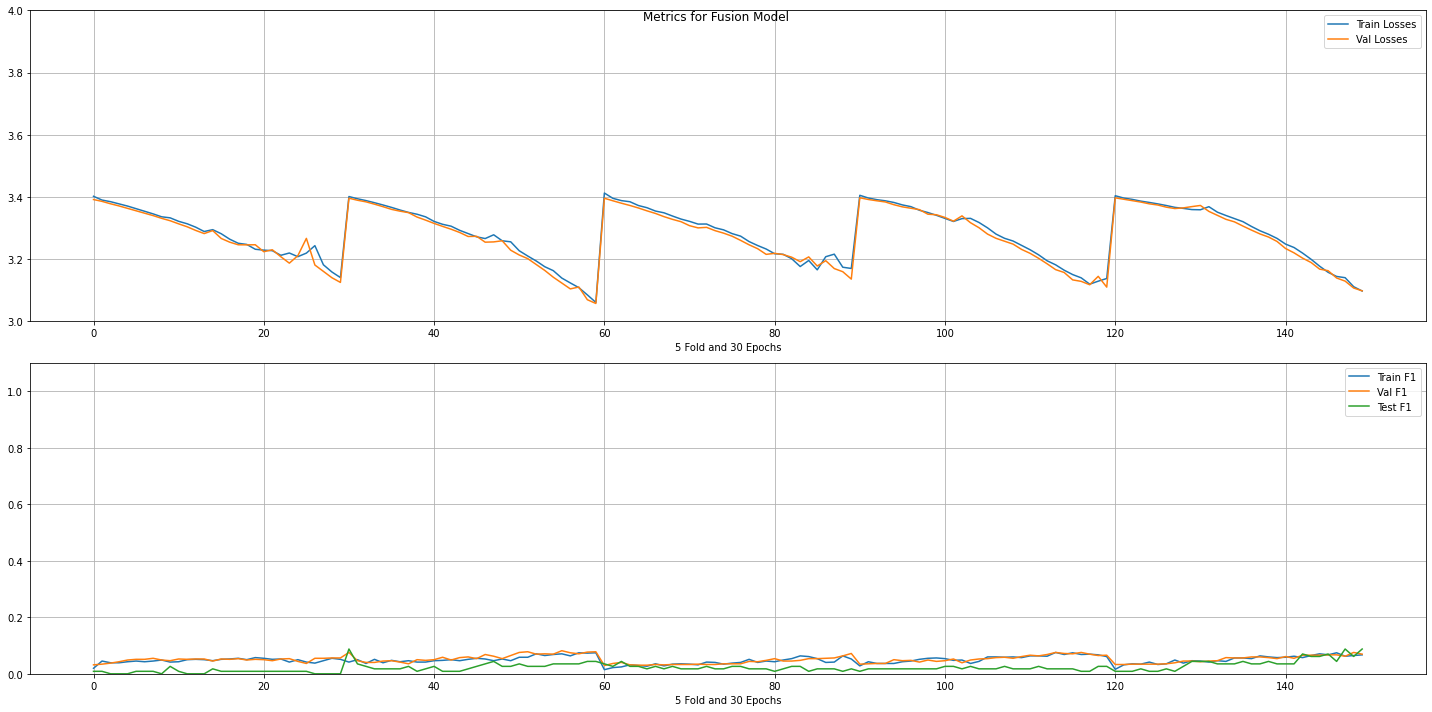

*** Cross Validation Score ***


,validation_f1,validation_precision,validation_recall,test_f1,test_precision,test_recall,train_f1,train_precision,train_recall
0,0.040304,0.093193,0.068293,0.020783,0.019597,0.035088,0.0349,0.110361,0.06122


In [30]:
indic_bert_result = train_model(data, test_data, '/content/drive/MyDrive/IndicBERT_FineTuned',
                                gpu, 'ai4bharat/indic-bert', n_labels=n_labels,feature='chroma', title='Fusion Model',
                                epochs=N_EPOCHS, target='RagamCode', model=FusionModel, lr=1e-5, mdlargs={'n_labels':n_labels},
                                fsize=(12,1876))

In [ ]:
display(HTML(results_to_df(indic_bert_result)[res_tbl_keys].to_html().replace("\\n", "<br>")))

# MURIL Fusion

FOLD 1 
 Data Sizes (Train/Validation) : 820/205


Downloading:   0%|          | 0.00/181 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/411 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.02M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/113 [00:00<?, ?B/s]

Some weights of the model checkpoint at /content/drive/MyDrive/MURIL_FineTuned/pytorch_model.bin were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Class Weights : [0.83333333 2.27777778 2.00980392 1.36666667 2.62820513 3.10606061
 1.13888889 1.36666667 0.94907407 1.79824561 1.42361111 3.41666667
 0.75925926 0.52564103 2.84722222 1.13888889 1.31410256 2.00980392
 2.44047619 2.44047619 0.66993464 0.63271605 0.38825758 1.70833333
 0.56010929 1.2202381  0.56010929 0.4495614  3.41666667 0.39272031]
Epoch 1/30 : Training Loss: 3.403 / Validation Loss : 3.397 [Time : 32.006402 seconds]
Epoch 2/30 : Training Loss: 3.395 / Validation Loss : 3.392 [Time : 31.557707 seconds]
Epoch 3/30 : Training Loss: 3.391 / Validation Loss : 3.388 [Time : 31.559885 seconds]
Epoch 4/30 : Training Loss: 3.389 / Validation Loss : 3.384 [Time : 31.746209 seconds]
Epoch 5/30 : Training Loss: 3.384 / Validation Loss : 3.380 [Time : 31.622262 seconds]
Epoch 6/30 : Training Loss: 3.381 / Validation Loss : 3.382 [Time : 27.75518 seconds]
Epoch 7/30 : Training Loss: 3.380 / Validation Loss : 3.373 [Time : 31.617549 seconds]
Epoch 8/30 : Training Loss: 3.373 / Vali

Some weights of the model checkpoint at /content/drive/MyDrive/MURIL_FineTuned/pytorch_model.bin were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/30 : Training Loss: 3.402 / Validation Loss : 3.396 [Time : 28.473147 seconds]
Epoch 2/30 : Training Loss: 3.397 / Validation Loss : 3.394 [Time : 28.221234 seconds]
Epoch 3/30 : Training Loss: 3.393 / Validation Loss : 3.390 [Time : 28.270585 seconds]
Epoch 4/30 : Training Loss: 3.392 / Validation Loss : 3.389 [Time : 28.356167 seconds]
Epoch 5/30 : Training Loss: 3.393 / Validation Loss : 3.392 [Time : 28.431378 seconds]
Epoch 6/30 : Training Loss: 3.394 / Validation Loss : 3.391 [Time : 28.280853 seconds]
Epoch 7/30 : Training Loss: 3.392 / Validation Loss : 3.390 [Time : 28.289441 seconds]
Epoch 8/30 : Training Loss: 3.389 / Validation Loss : 3.387 [Time : 28.231943 seconds]
Epoch 9/30 : Training Loss: 3.391 / Validation Loss : 3.390 [Time : 28.320471 seconds]
Epoch 10/30 : Training Loss: 3.390 / Validation Loss : 3.389 [Time : 28.332629 seconds]
Epoch 11/30 : Training Loss: 3.389 / Validation Loss : 3.387 [Time : 28.231942 seconds]
Epoch 12/30 : Training Loss: 3.387 / Vali

Some weights of the model checkpoint at /content/drive/MyDrive/MURIL_FineTuned/pytorch_model.bin were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/30 : Training Loss: 3.410 / Validation Loss : 3.400 [Time : 28.349233 seconds]
Epoch 2/30 : Training Loss: 3.401 / Validation Loss : 3.396 [Time : 28.28088 seconds]
Epoch 3/30 : Training Loss: 3.396 / Validation Loss : 3.394 [Time : 28.286618 seconds]
Epoch 4/30 : Training Loss: 3.395 / Validation Loss : 3.389 [Time : 28.297278 seconds]
Epoch 5/30 : Training Loss: 3.388 / Validation Loss : 3.385 [Time : 28.302689 seconds]
Epoch 6/30 : Training Loss: 3.387 / Validation Loss : 3.379 [Time : 28.253737 seconds]
Epoch 7/30 : Training Loss: 3.383 / Validation Loss : 3.379 [Time : 28.338403 seconds]
Epoch 8/30 : Training Loss: 3.378 / Validation Loss : 3.371 [Time : 28.268854 seconds]
Epoch 9/30 : Training Loss: 3.373 / Validation Loss : 3.365 [Time : 28.335516 seconds]
Epoch 10/30 : Training Loss: 3.367 / Validation Loss : 3.369 [Time : 28.266394 seconds]
Epoch 11/30 : Training Loss: 3.374 / Validation Loss : 3.358 [Time : 28.475833 seconds]
Epoch 12/30 : Training Loss: 3.360 / Valid

Some weights of the model checkpoint at /content/drive/MyDrive/MURIL_FineTuned/pytorch_model.bin were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/30 : Training Loss: 3.402 / Validation Loss : 3.400 [Time : 28.628342 seconds]
Epoch 2/30 : Training Loss: 3.400 / Validation Loss : 3.398 [Time : 28.387202 seconds]
Epoch 3/30 : Training Loss: 3.398 / Validation Loss : 3.397 [Time : 28.370819 seconds]
Epoch 4/30 : Training Loss: 3.398 / Validation Loss : 3.397 [Time : 28.337249 seconds]
Epoch 5/30 : Training Loss: 3.396 / Validation Loss : 3.394 [Time : 28.37783 seconds]
Epoch 6/30 : Training Loss: 3.394 / Validation Loss : 3.392 [Time : 28.377519 seconds]
Epoch 7/30 : Training Loss: 3.392 / Validation Loss : 3.390 [Time : 28.385993 seconds]
Epoch 8/30 : Training Loss: 3.391 / Validation Loss : 3.390 [Time : 28.567058 seconds]
Epoch 9/30 : Training Loss: 3.389 / Validation Loss : 3.389 [Time : 28.487243 seconds]
Epoch 10/30 : Training Loss: 3.387 / Validation Loss : 3.384 [Time : 28.913205 seconds]
Epoch 11/30 : Training Loss: 3.383 / Validation Loss : 3.379 [Time : 28.349251 seconds]
Epoch 12/30 : Training Loss: 3.382 / Valid

Some weights of the model checkpoint at /content/drive/MyDrive/MURIL_FineTuned/pytorch_model.bin were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/30 : Training Loss: 3.405 / Validation Loss : 3.397 [Time : 28.570937 seconds]
Epoch 2/30 : Training Loss: 3.397 / Validation Loss : 3.394 [Time : 28.364017 seconds]
Epoch 3/30 : Training Loss: 3.393 / Validation Loss : 3.391 [Time : 28.647757 seconds]
Epoch 4/30 : Training Loss: 3.389 / Validation Loss : 3.387 [Time : 28.370566 seconds]
Epoch 5/30 : Training Loss: 3.389 / Validation Loss : 3.384 [Time : 28.367028 seconds]
Epoch 6/30 : Training Loss: 3.386 / Validation Loss : 3.382 [Time : 28.479429 seconds]
Epoch 7/30 : Training Loss: 3.383 / Validation Loss : 3.378 [Time : 28.480988 seconds]
Epoch 8/30 : Training Loss: 3.385 / Validation Loss : 3.390 [Time : 28.504576 seconds]
Epoch 9/30 : Training Loss: 3.396 / Validation Loss : 3.393 [Time : 28.514542 seconds]
Epoch 10/30 : Training Loss: 3.397 / Validation Loss : 3.392 [Time : 28.370361 seconds]
Epoch 11/30 : Training Loss: 3.402 / Validation Loss : 3.402 [Time : 28.444427 seconds]
Epoch 12/30 : Training Loss: 3.404 / Vali

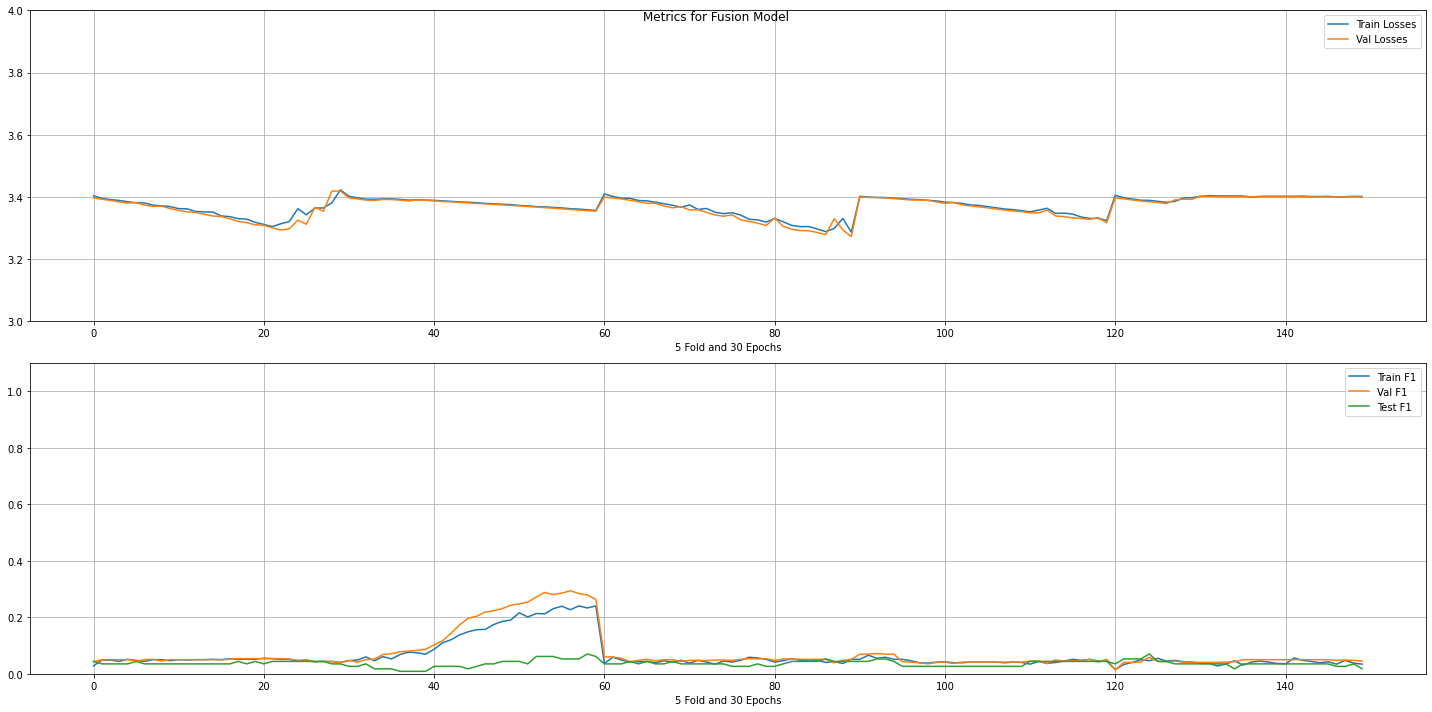

*** Cross Validation Score ***


,validation_f1,validation_precision,validation_recall,test_f1,test_precision,test_recall,train_f1,train_precision,train_recall
0,0.082579,0.421485,0.092439,0.018983,0.052118,0.047368,0.077645,0.277696,0.086585


In [32]:
muril_result = train_model(data, test_data, '/content/drive/MyDrive/MURIL_FineTuned',
                                gpu, 'google/muril-base-cased', n_labels=n_labels,feature='chroma', title='Fusion Model',
                                epochs=N_EPOCHS, target='RagamCode', model=FusionModel, lr=1e-5, mdlargs={'n_labels':n_labels},
                           fsize=(12,1876))

In [34]:
display(HTML(results_to_df(muril_result)[res_tbl_keys].to_html().replace("\\n", "<br>")))

,train_f1,validation_f1,test_f1,train_precision,validation_precision,test_precision,train_recall,validation_recall,test_recall
26,0.226829,0.293902,0.052632,0.226829,0.293902,0.052632,0.226829,0.293902,0.052632
23,0.212195,0.287805,0.061404,0.212195,0.287805,0.061404,0.212195,0.287805,0.061404
25,0.239024,0.285366,0.052632,0.239024,0.285366,0.052632,0.239024,0.285366,0.052632
27,0.240244,0.284146,0.052632,0.240244,0.284146,0.052632,0.240244,0.284146,0.052632
24,0.230488,0.280488,0.061404,0.230488,0.280488,0.061404,0.230488,0.280488,0.061404
28,0.232927,0.279268,0.070175,0.232927,0.279268,0.070175,0.232927,0.279268,0.070175
22,0.213415,0.271951,0.061404,0.213415,0.271951,0.061404,0.213415,0.271951,0.061404
29,0.240244,0.263415,0.061404,0.240244,0.263415,0.061404,0.240244,0.263415,0.061404
21,0.201220,0.253659,0.035088,0.201220,0.253659,0.035088,0.201220,0.253659,0.035088
20,0.215854,0.247561,0.043860,0.215854,0.247561,0.043860,0.215854,0.247561,0.043860


# XLM-R Fusion

FOLD 1 
 Data Sizes (Train/Validation) : 820/205


Downloading:   0%|          | 0.00/512 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.83M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/8.68M [00:00<?, ?B/s]

Some weights of the model checkpoint at /content/drive/MyDrive/XLMR_Finetuned/pytorch_model.bin were not used when initializing XLMRobertaModel: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaModel were not initialized from the model checkpoint at /content/drive/MyDrive/XLMR_Finetuned/pytorch_model.bin and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream

Class Weights : [0.83333333 2.27777778 2.00980392 1.36666667 2.62820513 3.10606061
 1.13888889 1.36666667 0.94907407 1.79824561 1.42361111 3.41666667
 0.75925926 0.52564103 2.84722222 1.13888889 1.31410256 2.00980392
 2.44047619 2.44047619 0.66993464 0.63271605 0.38825758 1.70833333
 0.56010929 1.2202381  0.56010929 0.4495614  3.41666667 0.39272031]
Epoch 1/30 : Training Loss: 3.406 / Validation Loss : 3.392 [Time : 31.924604 seconds]
Epoch 2/30 : Training Loss: 3.390 / Validation Loss : 3.384 [Time : 31.765203 seconds]
Epoch 3/30 : Training Loss: 3.385 / Validation Loss : 3.377 [Time : 31.825314 seconds]
Epoch 4/30 : Training Loss: 3.374 / Validation Loss : 3.367 [Time : 31.825953 seconds]
Epoch 5/30 : Training Loss: 3.369 / Validation Loss : 3.359 [Time : 31.880785 seconds]
Epoch 6/30 : Training Loss: 3.361 / Validation Loss : 3.353 [Time : 31.725668 seconds]
Epoch 7/30 : Training Loss: 3.355 / Validation Loss : 3.343 [Time : 31.778999 seconds]
Epoch 8/30 : Training Loss: 3.347 / Val

Some weights of the model checkpoint at /content/drive/MyDrive/XLMR_Finetuned/pytorch_model.bin were not used when initializing XLMRobertaModel: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaModel were not initialized from the model checkpoint at /content/drive/MyDrive/XLMR_Finetuned/pytorch_model.bin and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream

Epoch 1/30 : Training Loss: 3.405 / Validation Loss : 3.396 [Time : 27.497135 seconds]
Epoch 2/30 : Training Loss: 3.396 / Validation Loss : 3.391 [Time : 27.356654 seconds]
Epoch 3/30 : Training Loss: 3.391 / Validation Loss : 3.386 [Time : 27.68902 seconds]
Epoch 4/30 : Training Loss: 3.387 / Validation Loss : 3.381 [Time : 27.076115 seconds]
Epoch 5/30 : Training Loss: 3.383 / Validation Loss : 3.376 [Time : 27.00371 seconds]
Epoch 6/30 : Training Loss: 3.379 / Validation Loss : 3.374 [Time : 27.054857 seconds]
Epoch 7/30 : Training Loss: 3.374 / Validation Loss : 3.367 [Time : 27.236233 seconds]
Epoch 8/30 : Training Loss: 3.371 / Validation Loss : 3.364 [Time : 27.080447 seconds]
Epoch 9/30 : Training Loss: 3.364 / Validation Loss : 3.356 [Time : 27.18302 seconds]
Epoch 10/30 : Training Loss: 3.358 / Validation Loss : 3.353 [Time : 27.108056 seconds]
Epoch 11/30 : Training Loss: 3.351 / Validation Loss : 3.348 [Time : 27.059206 seconds]
Epoch 12/30 : Training Loss: 3.350 / Validat

Some weights of the model checkpoint at /content/drive/MyDrive/XLMR_Finetuned/pytorch_model.bin were not used when initializing XLMRobertaModel: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaModel were not initialized from the model checkpoint at /content/drive/MyDrive/XLMR_Finetuned/pytorch_model.bin and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream

Epoch 1/30 : Training Loss: 3.403 / Validation Loss : 3.393 [Time : 27.688266 seconds]
Epoch 2/30 : Training Loss: 3.394 / Validation Loss : 3.388 [Time : 27.067236 seconds]
Epoch 3/30 : Training Loss: 3.388 / Validation Loss : 3.381 [Time : 27.126242 seconds]
Epoch 4/30 : Training Loss: 3.380 / Validation Loss : 3.374 [Time : 27.088005 seconds]
Epoch 5/30 : Training Loss: 3.373 / Validation Loss : 3.367 [Time : 27.056707 seconds]
Epoch 6/30 : Training Loss: 3.372 / Validation Loss : 3.364 [Time : 27.087663 seconds]
Epoch 7/30 : Training Loss: 3.362 / Validation Loss : 3.353 [Time : 27.085674 seconds]
Epoch 8/30 : Training Loss: 3.357 / Validation Loss : 3.347 [Time : 27.034321 seconds]
Epoch 9/30 : Training Loss: 3.352 / Validation Loss : 3.338 [Time : 27.061362 seconds]
Epoch 10/30 : Training Loss: 3.352 / Validation Loss : 3.346 [Time : 27.05296 seconds]
Epoch 11/30 : Training Loss: 3.338 / Validation Loss : 3.326 [Time : 27.033382 seconds]
Epoch 12/30 : Training Loss: 3.332 / Valid

Some weights of the model checkpoint at /content/drive/MyDrive/XLMR_Finetuned/pytorch_model.bin were not used when initializing XLMRobertaModel: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaModel were not initialized from the model checkpoint at /content/drive/MyDrive/XLMR_Finetuned/pytorch_model.bin and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream

Epoch 1/30 : Training Loss: 3.405 / Validation Loss : 3.395 [Time : 27.619851 seconds]
Epoch 2/30 : Training Loss: 3.396 / Validation Loss : 3.389 [Time : 27.437037 seconds]
Epoch 3/30 : Training Loss: 3.389 / Validation Loss : 3.384 [Time : 27.81981 seconds]
Epoch 4/30 : Training Loss: 3.386 / Validation Loss : 3.379 [Time : 27.017758 seconds]
Epoch 5/30 : Training Loss: 3.380 / Validation Loss : 3.374 [Time : 27.012882 seconds]
Epoch 6/30 : Training Loss: 3.375 / Validation Loss : 3.369 [Time : 27.063273 seconds]
Epoch 7/30 : Training Loss: 3.372 / Validation Loss : 3.364 [Time : 27.031555 seconds]
Epoch 8/30 : Training Loss: 3.363 / Validation Loss : 3.359 [Time : 27.032921 seconds]
Epoch 9/30 : Training Loss: 3.360 / Validation Loss : 3.352 [Time : 27.140961 seconds]
Epoch 10/30 : Training Loss: 3.352 / Validation Loss : 3.345 [Time : 27.295133 seconds]
Epoch 11/30 : Training Loss: 3.350 / Validation Loss : 3.340 [Time : 27.0897 seconds]
Epoch 12/30 : Training Loss: 3.346 / Validat

Some weights of the model checkpoint at /content/drive/MyDrive/XLMR_Finetuned/pytorch_model.bin were not used when initializing XLMRobertaModel: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaModel were not initialized from the model checkpoint at /content/drive/MyDrive/XLMR_Finetuned/pytorch_model.bin and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream

Epoch 1/30 : Training Loss: 3.405 / Validation Loss : 3.397 [Time : 27.892279 seconds]
Epoch 2/30 : Training Loss: 3.398 / Validation Loss : 3.393 [Time : 27.747127 seconds]
Epoch 3/30 : Training Loss: 3.393 / Validation Loss : 3.388 [Time : 27.07862 seconds]
Epoch 4/30 : Training Loss: 3.390 / Validation Loss : 3.384 [Time : 27.234342 seconds]
Epoch 5/30 : Training Loss: 3.386 / Validation Loss : 3.379 [Time : 27.019186 seconds]
Epoch 6/30 : Training Loss: 3.380 / Validation Loss : 3.375 [Time : 27.006228 seconds]
Epoch 7/30 : Training Loss: 3.377 / Validation Loss : 3.368 [Time : 27.044477 seconds]
Epoch 8/30 : Training Loss: 3.371 / Validation Loss : 3.364 [Time : 27.034227 seconds]
Epoch 9/30 : Training Loss: 3.366 / Validation Loss : 3.359 [Time : 27.219724 seconds]
Epoch 10/30 : Training Loss: 3.363 / Validation Loss : 3.355 [Time : 27.028885 seconds]
Epoch 11/30 : Training Loss: 3.354 / Validation Loss : 3.348 [Time : 27.145855 seconds]
Epoch 12/30 : Training Loss: 3.353 / Valid

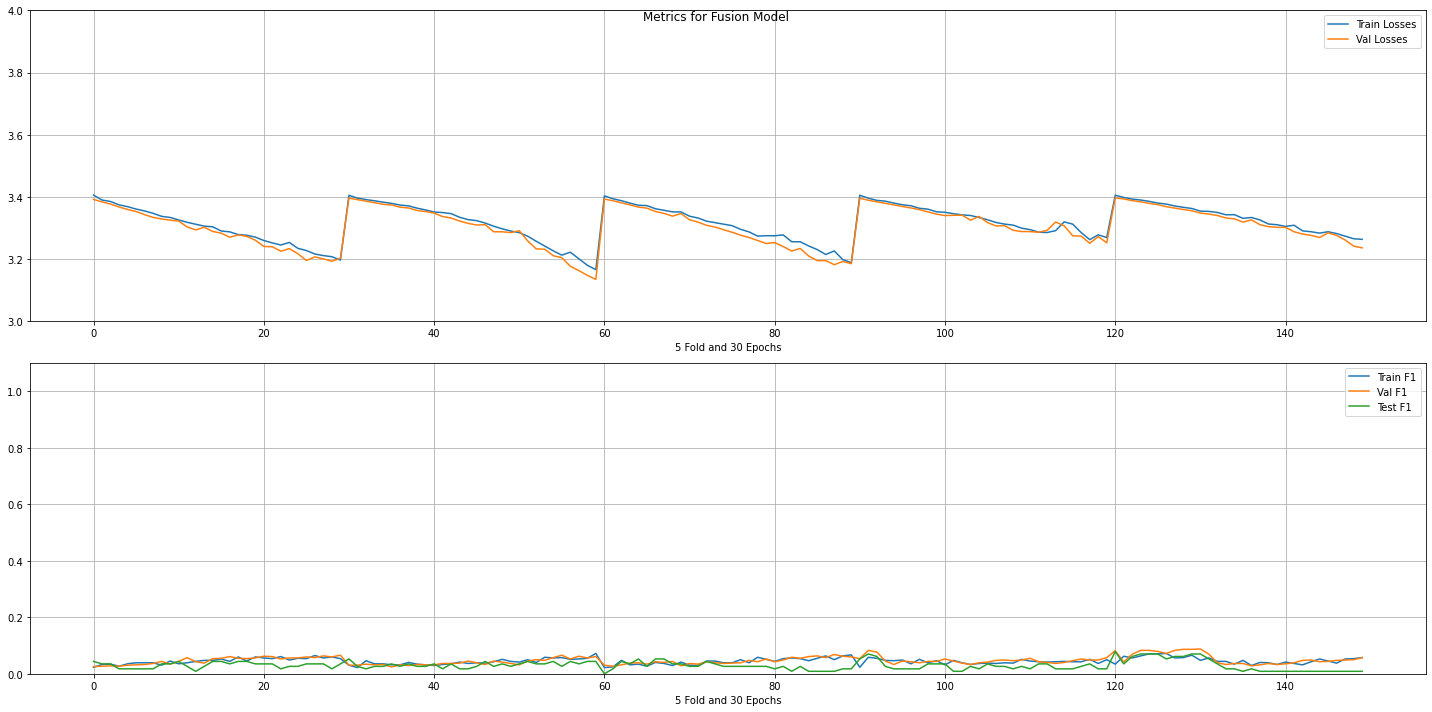

*** Cross Validation Score ***


,validation_f1,validation_precision,validation_recall,test_f1,test_precision,test_recall,train_f1,train_precision,train_recall
0,0.028117,0.033713,0.059024,0.009481,0.00779,0.022807,0.028978,0.114153,0.058049


In [36]:
xlmr_result = train_model(data, test_data, '/content/drive/MyDrive/XLMR_Finetuned',
                                gpu, 'xlm-roberta-base', n_labels=n_labels,feature='chroma', title='Fusion Model',
                                epochs=N_EPOCHS, target='RagamCode', model=FusionModel, lr=1e-5, mdlargs={'n_labels':n_labels},
                          fsize=(12,1876))

In [37]:
display(HTML(results_to_df(xlmr_result)[res_tbl_keys].to_html().replace("\\n", "<br>")))

,train_f1,validation_f1,test_f1,train_precision,validation_precision,test_precision,train_recall,validation_recall,test_recall
10,0.047561,0.087805,0.070175,0.047561,0.087805,0.070175,0.047561,0.087805,0.070175
9,0.065854,0.086585,0.070175,0.065854,0.086585,0.070175,0.065854,0.086585,0.070175
8,0.057317,0.086585,0.061404,0.057317,0.086585,0.061404,0.057317,0.086585,0.061404
4,0.070732,0.082927,0.070175,0.070732,0.082927,0.070175,0.070732,0.082927,0.070175
3,0.063415,0.082927,0.070175,0.063415,0.082927,0.070175,0.063415,0.082927,0.070175
1,0.058537,0.082927,0.070175,0.058537,0.082927,0.070175,0.058537,0.082927,0.070175
7,0.056098,0.082927,0.061404,0.056098,0.082927,0.061404,0.056098,0.082927,0.061404
0,0.034146,0.081707,0.078947,0.034146,0.081707,0.078947,0.034146,0.081707,0.078947
5,0.070732,0.079268,0.070175,0.070732,0.079268,0.070175,0.070732,0.079268,0.070175
2,0.054878,0.076829,0.061404,0.054878,0.076829,0.061404,0.054878,0.076829,0.061404


# MBERT Fusion

FOLD 1 
 Data Sizes (Train/Validation) : 820/205


Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/972k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.87M [00:00<?, ?B/s]

Some weights of the model checkpoint at /content/drive/MyDrive/MBERT_Finetuned/pytorch_model.bin were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Class Weights : [0.83333333 2.27777778 2.00980392 1.36666667 2.62820513 3.10606061
 1.13888889 1.36666667 0.94907407 1.79824561 1.42361111 3.41666667
 0.75925926 0.52564103 2.84722222 1.13888889 1.31410256 2.00980392
 2.44047619 2.44047619 0.66993464 0.63271605 0.38825758 1.70833333
 0.56010929 1.2202381  0.56010929 0.4495614  3.41666667 0.39272031]
Epoch 1/30 : Training Loss: 3.404 / Validation Loss : 3.390 [Time : 30.616511 seconds]
Epoch 2/30 : Training Loss: 3.389 / Validation Loss : 3.380 [Time : 30.013226 seconds]
Epoch 3/30 : Training Loss: 3.378 / Validation Loss : 3.371 [Time : 29.864405 seconds]
Epoch 4/30 : Training Loss: 3.371 / Validation Loss : 3.360 [Time : 29.884299 seconds]
Epoch 5/30 : Training Loss: 3.361 / Validation Loss : 3.352 [Time : 29.935383 seconds]
Epoch 6/30 : Training Loss: 3.352 / Validation Loss : 3.344 [Time : 29.917965 seconds]
Epoch 7/30 : Training Loss: 3.345 / Validation Loss : 3.337 [Time : 29.882835 seconds]
Epoch 8/30 : Training Loss: 3.338 / Val

Some weights of the model checkpoint at /content/drive/MyDrive/MBERT_Finetuned/pytorch_model.bin were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/30 : Training Loss: 3.404 / Validation Loss : 3.391 [Time : 25.602804 seconds]
Epoch 2/30 : Training Loss: 3.392 / Validation Loss : 3.384 [Time : 25.550868 seconds]
Epoch 3/30 : Training Loss: 3.379 / Validation Loss : 3.377 [Time : 25.839623 seconds]
Epoch 4/30 : Training Loss: 3.380 / Validation Loss : 3.369 [Time : 26.143678 seconds]
Epoch 5/30 : Training Loss: 3.365 / Validation Loss : 3.358 [Time : 25.891282 seconds]
Epoch 6/30 : Training Loss: 3.358 / Validation Loss : 3.349 [Time : 26.45255 seconds]
Epoch 7/30 : Training Loss: 3.349 / Validation Loss : 3.347 [Time : 25.974982 seconds]
Epoch 8/30 : Training Loss: 3.346 / Validation Loss : 3.327 [Time : 26.287866 seconds]
Epoch 9/30 : Training Loss: 3.332 / Validation Loss : 3.316 [Time : 26.159778 seconds]
Epoch 10/30 : Training Loss: 3.319 / Validation Loss : 3.304 [Time : 25.878663 seconds]
Epoch 11/30 : Training Loss: 3.308 / Validation Loss : 3.312 [Time : 25.934862 seconds]
Epoch 12/30 : Training Loss: 3.305 / Valid

Some weights of the model checkpoint at /content/drive/MyDrive/MBERT_Finetuned/pytorch_model.bin were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/30 : Training Loss: 3.401 / Validation Loss : 3.378 [Time : 25.571047 seconds]
Epoch 2/30 : Training Loss: 3.378 / Validation Loss : 3.362 [Time : 25.558826 seconds]
Epoch 3/30 : Training Loss: 3.358 / Validation Loss : 3.350 [Time : 26.103808 seconds]
Epoch 4/30 : Training Loss: 3.351 / Validation Loss : 3.338 [Time : 25.89716 seconds]
Epoch 5/30 : Training Loss: 3.340 / Validation Loss : 3.328 [Time : 26.228583 seconds]
Epoch 6/30 : Training Loss: 3.337 / Validation Loss : 3.315 [Time : 25.880489 seconds]
Epoch 7/30 : Training Loss: 3.316 / Validation Loss : 3.302 [Time : 26.012978 seconds]
Epoch 8/30 : Training Loss: 3.319 / Validation Loss : 3.304 [Time : 25.930163 seconds]
Epoch 9/30 : Training Loss: 3.312 / Validation Loss : 3.313 [Time : 26.085436 seconds]
Epoch 10/30 : Training Loss: 3.311 / Validation Loss : 3.296 [Time : 25.98417 seconds]
Epoch 11/30 : Training Loss: 3.286 / Validation Loss : 3.289 [Time : 25.899689 seconds]
Epoch 12/30 : Training Loss: 3.285 / Valida

Some weights of the model checkpoint at /content/drive/MyDrive/MBERT_Finetuned/pytorch_model.bin were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/30 : Training Loss: 3.419 / Validation Loss : 3.388 [Time : 25.854668 seconds]
Epoch 2/30 : Training Loss: 3.386 / Validation Loss : 3.376 [Time : 26.7346 seconds]
Epoch 3/30 : Training Loss: 3.376 / Validation Loss : 3.366 [Time : 25.871135 seconds]
Epoch 4/30 : Training Loss: 3.368 / Validation Loss : 3.357 [Time : 25.880624 seconds]
Epoch 5/30 : Training Loss: 3.359 / Validation Loss : 3.349 [Time : 26.034208 seconds]
Epoch 6/30 : Training Loss: 3.344 / Validation Loss : 3.333 [Time : 25.895271 seconds]
Epoch 7/30 : Training Loss: 3.342 / Validation Loss : 3.322 [Time : 25.840004 seconds]
Epoch 8/30 : Training Loss: 3.330 / Validation Loss : 3.312 [Time : 26.043478 seconds]
Epoch 9/30 : Training Loss: 3.313 / Validation Loss : 3.301 [Time : 25.814026 seconds]
Epoch 10/30 : Training Loss: 3.305 / Validation Loss : 3.307 [Time : 25.851816 seconds]
Epoch 11/30 : Training Loss: 3.304 / Validation Loss : 3.280 [Time : 26.378683 seconds]
Epoch 12/30 : Training Loss: 3.280 / Valida

Some weights of the model checkpoint at /content/drive/MyDrive/MBERT_Finetuned/pytorch_model.bin were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/30 : Training Loss: 3.401 / Validation Loss : 3.389 [Time : 25.705959 seconds]
Epoch 2/30 : Training Loss: 3.390 / Validation Loss : 3.382 [Time : 25.490066 seconds]
Epoch 3/30 : Training Loss: 3.385 / Validation Loss : 3.378 [Time : 25.506938 seconds]
Epoch 4/30 : Training Loss: 3.377 / Validation Loss : 3.372 [Time : 25.206744 seconds]
Epoch 5/30 : Training Loss: 3.373 / Validation Loss : 3.369 [Time : 25.205726 seconds]
Epoch 6/30 : Training Loss: 3.371 / Validation Loss : 3.359 [Time : 25.454621 seconds]
Epoch 7/30 : Training Loss: 3.359 / Validation Loss : 3.346 [Time : 25.229858 seconds]
Epoch 8/30 : Training Loss: 3.350 / Validation Loss : 3.336 [Time : 25.228619 seconds]
Epoch 9/30 : Training Loss: 3.333 / Validation Loss : 3.323 [Time : 25.22076 seconds]
Epoch 10/30 : Training Loss: 3.322 / Validation Loss : 3.314 [Time : 25.390681 seconds]
Epoch 11/30 : Training Loss: 3.315 / Validation Loss : 3.301 [Time : 25.255929 seconds]
Epoch 12/30 : Training Loss: 3.323 / Valid

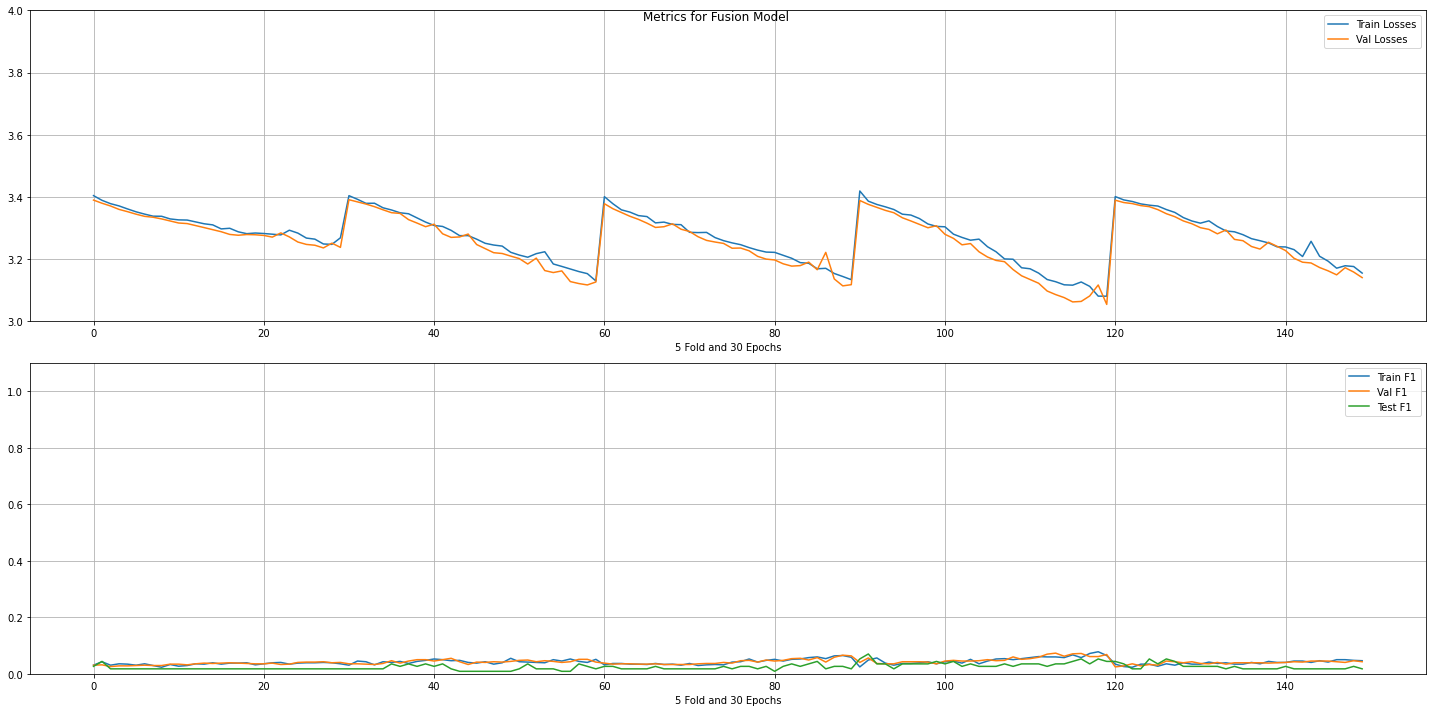

*** Cross Validation Score ***


,validation_f1,validation_precision,validation_recall,test_f1,test_precision,test_recall,train_f1,train_precision,train_recall
0,0.021978,0.026413,0.054146,0.009159,0.008223,0.026316,0.024083,0.168743,0.05122


In [38]:
mbert_result = train_model(data, test_data, '/content/drive/MyDrive/MBERT_Finetuned',
                                gpu, 'bert-base-multilingual-cased', n_labels=n_labels,feature='chroma', title='Fusion Model',
                                epochs=N_EPOCHS, target='RagamCode', model=FusionModel, lr=1e-5, mdlargs={'n_labels':n_labels},
                           fsize=(12,1876))

In [39]:
display(HTML(results_to_df(mbert_result)[res_tbl_keys].to_html().replace("\\n", "<br>")))

,train_f1,validation_f1,test_f1,train_precision,validation_precision,test_precision,train_recall,validation_recall,test_recall
23,0.059756,0.073171,0.035088,0.059756,0.073171,0.035088,0.059756,0.073171,0.035088
26,0.057317,0.071951,0.052632,0.057317,0.071951,0.052632,0.057317,0.071951,0.052632
25,0.067073,0.070732,0.043860,0.067073,0.070732,0.043860,0.067073,0.070732,0.043860
22,0.059756,0.069512,0.026316,0.059756,0.069512,0.026316,0.059756,0.069512,0.026316
29,0.064634,0.068293,0.043860,0.064634,0.068293,0.043860,0.064634,0.068293,0.043860
28,0.064634,0.065854,0.026316,0.064634,0.065854,0.026316,0.064634,0.065854,0.026316
29,0.058537,0.063415,0.017544,0.058537,0.063415,0.017544,0.058537,0.063415,0.017544
24,0.057317,0.062195,0.035088,0.057317,0.062195,0.035088,0.057317,0.062195,0.035088
28,0.078049,0.060976,0.052632,0.078049,0.060976,0.052632,0.078049,0.060976,0.052632
27,0.071951,0.060976,0.035088,0.071951,0.060976,0.035088,0.071951,0.060976,0.035088
